In [1]:
import numpy as np
import matplotlib.pyplot as plt

ps = (2,3,5,10,20,50,100,200,500)        #different choices for matrix dimension
a = np.linspace(0.0, 2*np.pi, 100)
x_circ = np.sin(a)
y_circ = np.cos(a)

distribution of random matrices with normal entries

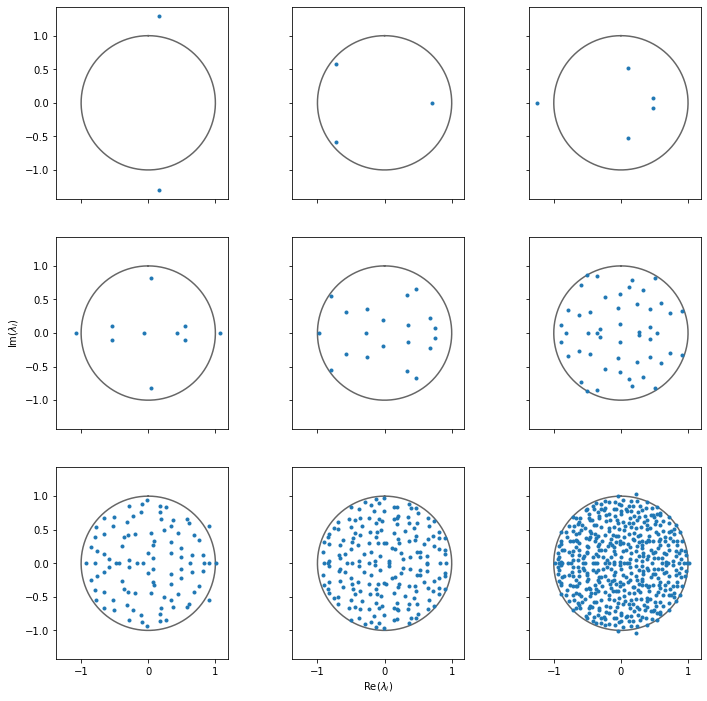

In [2]:
fig,axs = plt.subplots(3,3,subplot_kw={'aspect':1.0}, figsize=(12,12), sharex=True, sharey=True)
for p,ax in zip(ps,axs.flat):
    eig = np.linalg.eigvals(np.random.normal(size=(p,p)))
    ax.plot(x_circ, y_circ, color='0.4')
    ax.plot(eig.real/np.sqrt(p), eig.imag/np.sqrt(p), marker='.', ls='none')
axs[-1,1].set_xlabel('Re($\lambda_i$)')
axs[1,0].set_ylabel('Im($\lambda_i$)')
None

distribution of random matrices with uniform entries

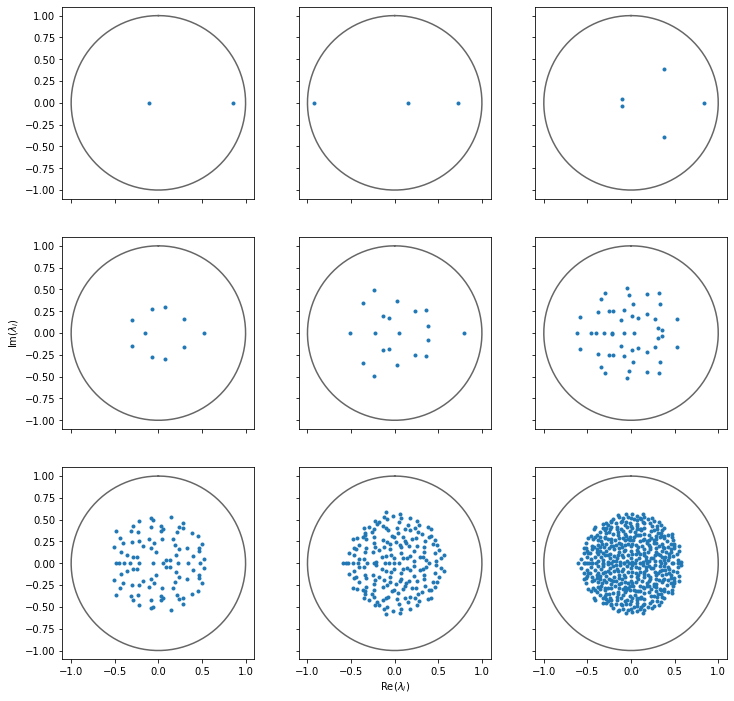

In [3]:
fig,axs = plt.subplots(3,3,subplot_kw={'aspect':1.0}, figsize=(12,12), sharex=True, sharey=True)
for p,ax in zip(ps,axs.flat):
    eig = np.linalg.eigvals(np.random.uniform(size=(p,p), low=-1.0, high=1.0))
    ax.plot(x_circ, y_circ, color='0.4')
    ax.plot(eig.real/np.sqrt(p), eig.imag/np.sqrt(p), marker='.', ls='none')
axs[-1,1].set_xlabel('Re($\lambda_i$)')
axs[1,0].set_ylabel('Im($\lambda_i$)')
None

histogram of distribution

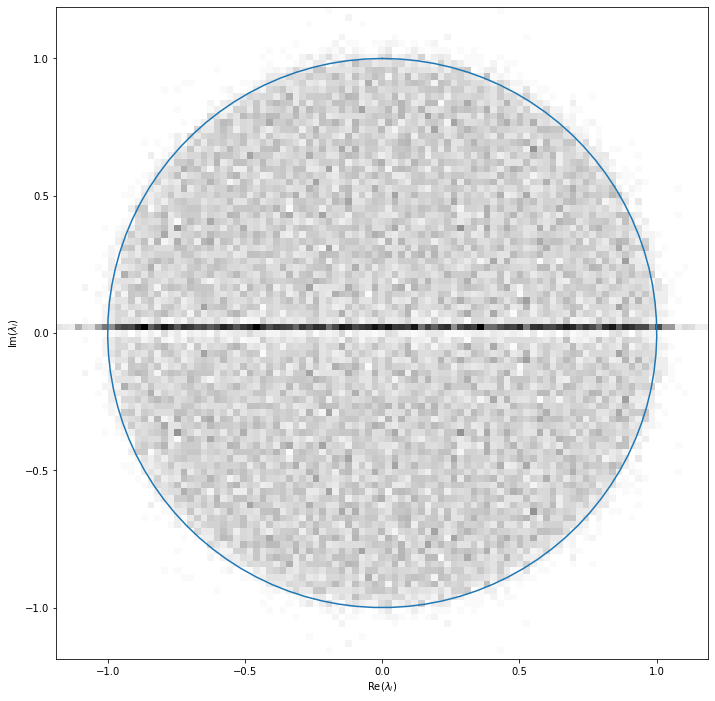

In [4]:
niter = 50
bin_edges = np.linspace(-1.2, 1.2, 101)
bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
hist = np.zeros((bin_edges.size-1,bin_edges.size-1))

for p in ps:
    sqrt_p = np.sqrt(p)
    for i in range(niter):
        eig = np.linalg.eigvals(np.random.normal(size=(p,p)))
        hist += np.histogram2d(x=eig.real/sqrt_p, y=eig.imag/sqrt_p, bins=(bin_edges,bin_edges))[0]

fig, ax = plt.subplots(subplot_kw={'aspect':1.0}, figsize=(12,12))
ax.pcolormesh(bin_centers, bin_centers, hist.T, cmap=plt.get_cmap('gray_r'))
ax.plot(x_circ, y_circ)
ax.set(xlabel='Re($\lambda_i$)', ylabel='Im($\lambda_i$)')
None

a look at the radius

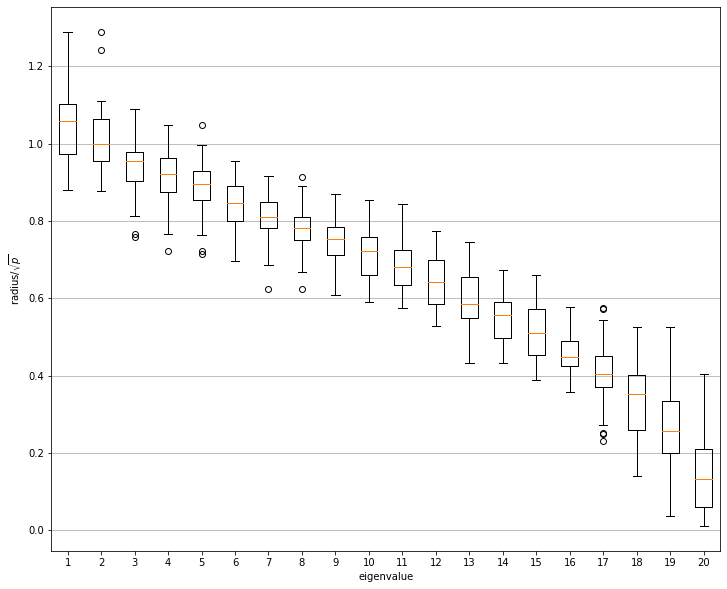

In [6]:
niter = 50
p = 20

rad = np.empty((niter,p))
for i in range(niter):
    eig = np.linalg.eigvals(np.random.normal(size=(p,p)))
    rad[i,:] = np.sqrt((eig.real)**2 + (eig.imag)**2)/np.sqrt(p)

rad.sort(axis=1)

fig, ax = plt.subplots(figsize=(12,10))
ax.boxplot(rad[:,::-1])
ax.yaxis.grid(True)
ax.set(xlabel='eigenvalue', ylabel='radius/$\sqrt{p}$')
None

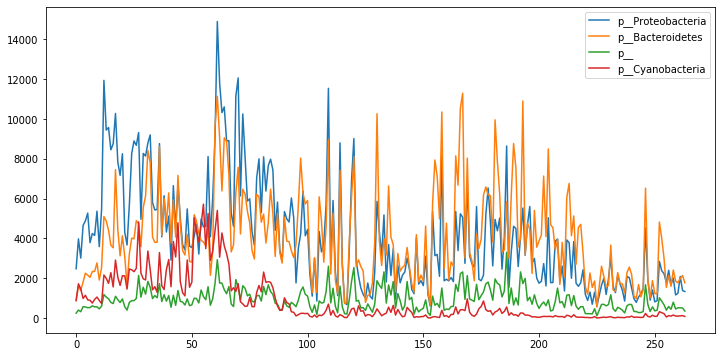

In [2]:
import pystan
import pandas

p = 4

DAT = pandas.read_csv('../../bayesian_cbiomes/case_studies/MV_AR1/data/bacterial_OTU.csv')

# Aggregate the data by phyla, which is indicated in the third column ("phylum") of the dataset:
phyla = np.unique(DAT['phylum']) # extract unique phyla IDs

# sum all OTUs of that phylum
# use sums as rows for new DataFrame
PHY = pandas.DataFrame([DAT.loc[DAT['phylum']==phylum].iloc[:,8:].sum() for phylum in phyla])
# associate each row with phylum
PHY = PHY.set_index(phyla)
PHY.sum(axis=1)

index_maxp = np.argsort(PHY.sum(axis=1).values)[-p:][::-1]

PHY = PHY.iloc[index_maxp]

fig,ax = plt.subplots(figsize=(12,6))
ax.plot(PHY.values.T)
ax.legend(PHY.index)
None

In [3]:
mod_code = '''data {
    int T;         //length of time series
    int p;         //number of variables
    matrix[p,T] Y; //matrix of observations; variables are rows; time is columns
    real phi_mu;   //PHI prior distribution parameter
    real phi_sigma; //PHI prior distribution parameter
}
parameters{
    matrix[p,p] PHI;     //dynamics matrix
    vector<lower=1E-15>[p] sigma;     //variances of stochastic forcing
    vector[p] init;      //mean of initial conditions as parameter vector
}
model{
    for (icol in 1:p){
        PHI[,icol] ~ normal(phi_mu,phi_sigma);
    }
    Y[,1] ~ normal(init, sigma);            //distribution of the initial conditions
    for(i in 2:T){
        Y[,i] ~ normal(PHI*Y[,i-1],sigma);  //conditional predictive distribution
    }
}
'''
mod = pystan.StanModel(model_code=mod_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dd1ea11859c7683002ab7f53f1a0b8e4 NOW.


In [4]:
phi_mu = 0.0
phi_sigma = 1.0

dat_PHY = {'T':PHY.shape[1], 'p':PHY.shape[0], 'Y':PHY.values, 'phi_mu':phi_mu, 'phi_sigma':phi_sigma}
mcmc = mod.sampling(data=dat_PHY, iter=2000, warmup=1000)
print(mcmc)

Inference for Stan model: anon_model_dd1ea11859c7683002ab7f53f1a0b8e4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
PHI[1,1]   0.77  1.1e-3   0.09    0.6   0.71   0.77   0.83   0.94   5888    1.0
PHI[2,1]   0.04  1.2e-3   0.09  -0.14  -0.01   0.04    0.1   0.22   5637    1.0
PHI[3,1] 2.0e-3  3.1e-4   0.02  -0.04  -0.01 2.2e-3   0.02   0.05   5202    1.0
PHI[4,1]   0.05  3.1e-4   0.02 2.7e-3   0.04   0.05   0.07    0.1   6333    1.0
PHI[1,2]   0.13  1.2e-3   0.09  -0.05   0.07   0.13   0.19    0.3   5773    1.0
PHI[2,2]   0.67  1.2e-3   0.09    0.5   0.61   0.68   0.74   0.86   6291    1.0
PHI[3,2]   0.08  3.1e-4   0.02   0.03   0.06   0.08    0.1   0.13   5511    1.0
PHI[4,2]   0.01  3.3e-4   0.03  -0.04-5.8e-3   0.01   0.03   0.06   5965    1.0
PHI[1,3]  -0.36  4.6e-3   0.37   -1.1   -0.6  -0.36  -0.11   0.37   6490    1.0
PHI[2,3]   

In [34]:
niter = 2000
bin_edges = np.linspace(-1.2, 1.2, 101)
bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
hist_prior = np.zeros((bin_edges.size-1,bin_edges.size-1))
hist_posterior = np.zeros((bin_edges.size-1,bin_edges.size-1))

sqrt_p = np.sqrt(p)
for i in range(niter):
    eig = np.linalg.eigvals(np.random.normal(size=(p,p), loc=phi_mu, scale=phi_sigma))
    hist_prior += np.histogram2d(x=eig.real/sqrt_p, y=eig.imag/sqrt_p, bins=(bin_edges,bin_edges))[0]

for i in range(mcmc['PHI'].shape[0]):
    eig = np.linalg.eigvals(mcmc['PHI'][i,:,:])
    hist_posterior += np.histogram2d(x=eig.real/sqrt_p, y=eig.imag/sqrt_p, bins=(bin_edges,bin_edges))[0]


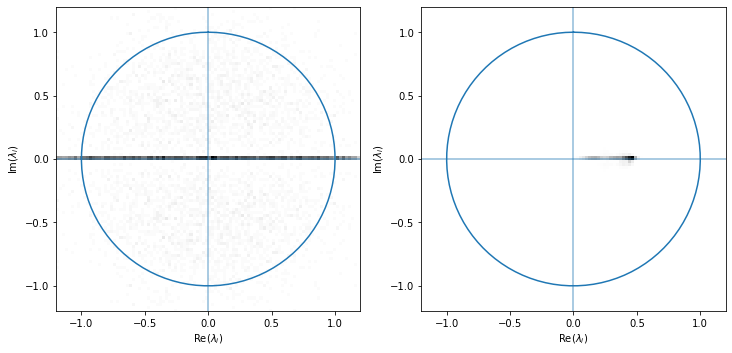

In [35]:
fig, axs = plt.subplots(ncols=2, subplot_kw={'aspect':1.0}, figsize=(12,6))
axs[0].pcolormesh(bin_edges, bin_edges, hist_prior.T, cmap=plt.get_cmap('gray_r'))
axs[1].pcolormesh(bin_edges, bin_edges, hist_posterior.T, cmap=plt.get_cmap('gray_r'))
for ax in axs.flat:
    ax.plot(x_circ, y_circ)
    ax.axvline(0.0, color='C0', alpha=0.5)
    ax.axhline(0.0, color='C0', alpha=0.5)
    ax.set(xlabel='Re($\lambda_i$)', ylabel='Im($\lambda_i$)')
ax
None